# Executive Summary

This project builds a forecasting framework for iPhone unit sales by modeling two key drivers:
(1) product lifecycle dynamics (launch spike → decay) and
(2) calendar seasonality (holiday effects).

Models are trained on historical generations (iPhone 12–15), validated on a held-out generation (iPhone 16), and used to forecast the next generation (iPhone 17).

Additional analyses include ablation studies, error diagnostics over time, launch-timing sensitivity, and a share-based approach to approximate cannibalization.

The goal is interpretability and decision support, not point-perfect prediction.

In [26]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re

In [27]:
file_name = "Iphone_Sales_Data.csv"
CSV_FILE = os.path.join(file_name)

In [28]:
df =pd.read_csv(CSV_FILE)
df= df.dropna(axis=1)
df["year"] = pd.to_datetime(df["Date"]).dt.year
df = df.sort_values(["Model", "Month"])
df["months_since_launch"] = df.groupby("Model").cumcount() + 1
df.head()

,Date,Model,Month,Estimated_Units_Millions,year,months_since_launch
0,10/1/2020,iPhone 12,1,0.751455,2020,1
1,10/2/2020,iPhone 12,2,0.727585,2020,2
2,10/3/2020,iPhone 12,3,0.776188,2020,3
3,10/4/2020,iPhone 12,4,0.829549,2020,4
4,10/5/2020,iPhone 12,5,0.698765,2020,5


In [29]:
df = df.copy()
df = df.sort_values(["Month", "Model"])

all_months = np.arange(df["Month"].min(), df["Month"].max() + 1)
all_models = df["Model"].unique()

panel = (
    df.set_index(["Month", "Model"])["Estimated_Units_Millions"]
      .reindex(pd.MultiIndex.from_product([all_months, all_models], names=["Month", "Model"]))
      .fillna(0.0)
      .reset_index()
      .rename(columns={"Estimated_Units_Millions": "sales"})
)
total = panel.groupby("Month")["sales"].sum().reset_index(name="total_sales")
panel = panel.merge(total, on="Month", how="left")
panel["share"] = np.where(panel["total_sales"] > 0, panel["sales"] / panel["total_sales"], 0.0)
launch_month = (
    panel[panel["sales"] > 0]
    .groupby("Model")["Month"]
    .min()
    .rename("launch_month")
    .reset_index()
)

panel = panel.merge(launch_month, on="Model", how="left")

panel["months_since_launch"] = panel["Month"] - panel["launch_month"] + 1

def fit_share_model_for_one_model(d, degree=2, alpha=1.0):
    d = d[(d["months_since_launch"] >= 1) & (d["total_sales"] > 0)].copy()
    # feature: log time since launch
    X = np.log1p(d[["months_since_launch"]].values)
    y = d["share"].values
    
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("ridge", Ridge(alpha=alpha))
    ])
    model.fit(X, y)
    return model
model_names = list(df['Model'].unique())
dfs_models = {}
s =0
for m, g in df.groupby("Model"):
    g = g.sort_values("Month") 
    g = g.reset_index(drop=True)
    g["Month"] = range(1, len(g) + 1)
    dfs_models[m] = g
    s+=len(g)

for m in model_names:
    print(dfs_models[m].head())



        Date      Model  Month  Estimated_Units_Millions  year  \
0  10/1/2020  iPhone 12      1                  0.751455  2020   
1  10/2/2020  iPhone 12      2                  0.727585  2020   
2  10/3/2020  iPhone 12      3                  0.776188  2020   
3  10/4/2020  iPhone 12      4                  0.829549  2020   
4  10/5/2020  iPhone 12      5                  0.698765  2020   

   months_since_launch  
0                    1  
1                    2  
2                    3  
3                    4  
4                    5  
       Date      Model  Month  Estimated_Units_Millions  year  \
0  9/1/2021  iPhone 13      1                  0.287606  2021   
1  9/2/2021  iPhone 13      2                  0.291830  2021   
2  9/3/2021  iPhone 13      3                  0.280171  2021   
3  9/4/2021  iPhone 13      4                  0.343082  2021   
4  9/5/2021  iPhone 13      5                  0.313227  2021   

   months_since_launch  
0                    1  
1           

In [30]:
df.columns

Index(['Date', 'Model', 'Month', 'Estimated_Units_Millions', 'year',
       'months_since_launch'],
      dtype='object')

How was data used?  

General Summary 

The data consists of time-series sales estimates for multiple iPhone generations. The data was first cleaned and standardized to ensure consistent date handling and model identification. Sales were aggregated at the monthly level where appropriate, and each iPhone generation was aligned using a months-since-launch variable so that lifecycle behavior could be compared across products independent of calendar time. Exploratory analysis showed strong lifecycle effects, overlapping product sales, and evidence of substitution between models, indicating that newer iPhones partially cannibalize demand from older ones. Seasonality was present but secondary to lifecycle and replacement effects.

<function matplotlib.pyplot.show(close=None, block=None)>

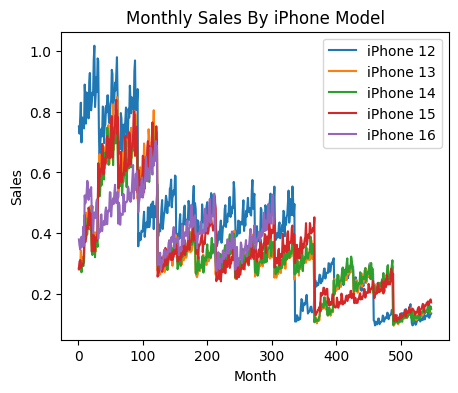

In [31]:
plt.figure(figsize=(5,4))
model_names= df['Model'].unique()
for m in model_names:
    sns.lineplot(data=dfs_models[m],x="Month",y="Estimated_Units_Millions",label =m)

plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Monthly Sales By iPhone Model")
plt.legend()
plt.show

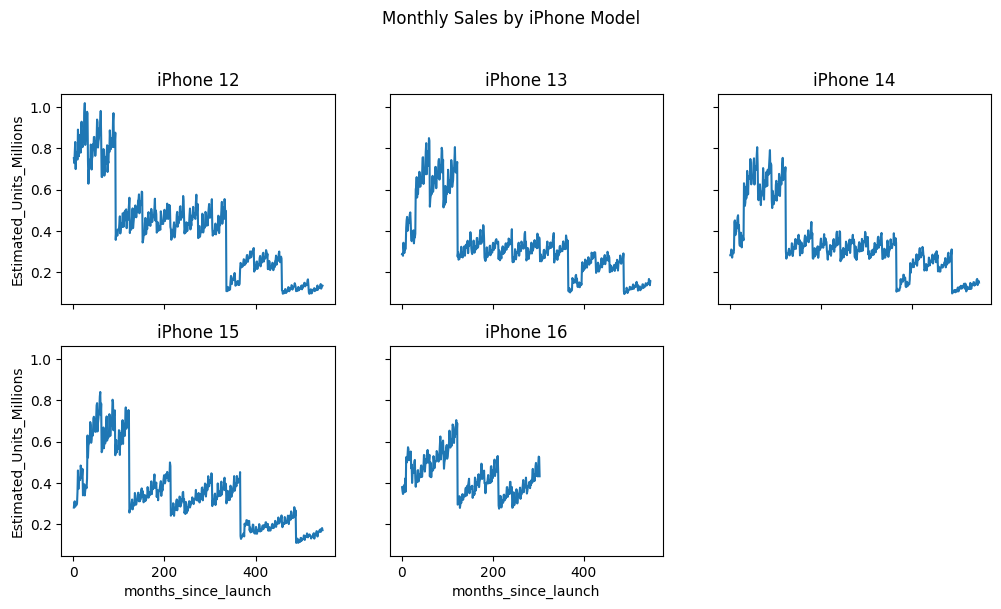

In [32]:
n = len(model_names)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*3), sharex=True, sharey=True)
axes = axes.flatten()

for ax, m in zip(axes, model_names):
    sns.lineplot(
        data=dfs_models[m],
        x="months_since_launch",
        y="Estimated_Units_Millions",
        ax=ax
    )
    ax.set_title(m)

# Remove empty panels
for ax in axes[len(model_names):]:
    ax.remove()

fig.suptitle("Monthly Sales by iPhone Model", y=1.02)
plt.show()


Visual Inference: 

All iPhones have a strong downward level shift over time. Newer Models stabilize lower. 
iPhone 12, 13, 14 show a launch ramp: low >> sharp rise >> peak >> drop
iPhone 15 shows a stronger launch peak with less initial lag
iPhone 16 appears mid-cycle, not fully observed

Sales trajectories across iPhone models are dominated by product life-cycle effects characterized by sharp launch ramps, discrete downward level shifts, and eventual stabilization at lower levels. Seasonal variation appears weak relative to these regime changes, suggesting that time-since-launch is a more informative temporal dimension than calendar month.

Using months since launch aligns products by life-cycle stage, does not account for direct cannibalism effects from newer models and allowing seasonality to be visualized more clearly. This treats the iPhone sales data as conditionally independent—a simplifying but potentially dangerous assumption.

Moving forward we would need to unde


### This report has 3 models, the first 2 are just direct Ridge regression that models for seasonality and the last model was constructed to predict micro variations within seasonality. 

A short summary for each model: 

Attempt 1: Ridge regression, Sales was normalized using the maximum sales value. Why? to be able to understand the first rapid spike. This led to over shooting. But Mean Absolute Error = 0.11 so operations would need to accomodate with 110k units of demand mismatch/day. 

Attempt 2: Wanted to reduce the error and wanted to reduce the inital overshooting, accomplished by revog the peak normalization frbove. Mean Absolute Error, dipped to 0.08 s A solid improvement over the previous without considering the adjustment for residuals. After modeling microvariations the  error went up to 0.86 and hence the need to find a better way to model was necessary, therefore Attempt 3. 

Attempt 3:  The intention was to model the behavious across varios stages of the product launch without worrying about the numbers and accounting for how the release of new products harm the sales of the existing product. Here, each year was modeled separately as individual models from past data. and then an average of all previous predictions were taken to give the final result. The Error for iPhone 16 Predictions dipped  to 0.072. But I think by modeling cannibalism effects more deliberately we can have more reliable models. 

That being said I would recommend to use the 2nd model and with more experimentation the 3rd one can work as well.


## iPhone 16 Prediction Attempt 1

ERROR; 0.11462402683798265


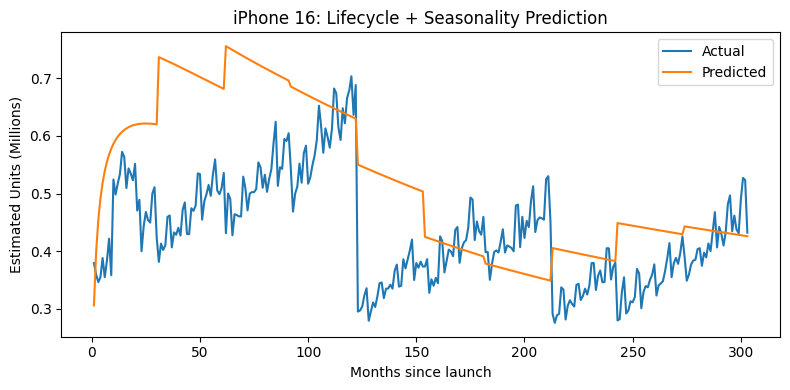

In [33]:


MODEL_COL = "Model"
DATE_COL = "Date"                     
SALES_COL = "Estimated_Units_Millions"

TRAIN_MODELS = ["iPhone 12", "iPhone 13", "iPhone 14", "iPhone 15"]
TARGET_MODEL = "iPhone 16"
ANCHOR_MONTHS = 3
POLY_DEGREE = 2
RIDGE_ALPHA = 10.0


df = df.copy()
df[DATE_COL] = pd.to_datetime(df[DATE_COL])

df = df.sort_values([MODEL_COL, DATE_COL]).reset_index(drop=True)
df["months_since_launch"] = df.groupby(MODEL_COL).cumcount() + 1


df["month"] = df[DATE_COL].dt.month
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)


train_df = df[df[MODEL_COL].isin(TRAIN_MODELS)].copy()
df_16 = df[df[MODEL_COL] == TARGET_MODEL].copy()


peak = train_df.groupby(MODEL_COL)[SALES_COL].max().rename("peak_sales")
train_df = train_df.merge(peak, on=MODEL_COL)
train_df["sales_norm"] = train_df[SALES_COL] / train_df["peak_sales"]


X = np.column_stack([
    np.log1p(train_df["months_since_launch"].values),
    train_df["month_sin"].values,
    train_df["month_cos"].values
])
y = train_df["sales_norm"].values

model = Pipeline([
    ("poly", PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)),
    ("ridge", Ridge(alpha=RIDGE_ALPHA))
])

model.fit(X, y)


X16 = np.column_stack([
    np.log1p(df_16["months_since_launch"].values),
    df_16["month_sin"].values,
    df_16["month_cos"].values
])

df_16["sales_pred"] = model.predict(X16)
MAE_appemt1 = mean_absolute_error( model.predict(X16), df_16[SALES_COL])
print(f"ERROR; {MAE_appemt1}")
plt.figure(figsize=(8,4))
sns.lineplot(data=df_16, x="months_since_launch", y=SALES_COL, label="Actual")
sns.lineplot(data=df_16, x="months_since_launch", y="sales_pred", label="Predicted")
plt.title("iPhone 16: Lifecycle + Seasonality Prediction")
plt.xlabel("Months since launch")
plt.ylabel("Estimated Units (Millions)")
plt.legend()
plt.tight_layout()
plt.show()


The initial model attempted to explain product lifecycle, replacement effects, and seasonality within a single smooth function. As a result, it systematically overestimated sales during certain periods, particularly early in the lifecycle, because it relied on peak normalization that amplified short-term launch effects. By modeling main effects and residual seasonal effects and avoiding peak normalization of sales, the revised version better models sales. 

## Iphone 16 Prediction -Attempt 2

In [34]:
def pick_col(cands, cols):
    "Match Columns Case Insensitively"
    cols_l = {c.lower(): c for c in cols}
    for k in cands:
        if k.lower() in cols_l:
            return cols_l[k.lower()]
    return None

def extract_gen(x):
    "Extract the generation of the iPhone"
    m = re.search(r"\b(1[0-9])\b", str(x))
    return int(m.group(1)) if m else np.nan

def prep_df(df):
    cols = list(df.columns)

    model_col = pick_col(["Model", "model", "iPhone", "iphone"], cols)
    if model_col is None:
        for c in cols:
            if df[c].dtype == "object" and df[c].astype(str).str.contains("iphone", case=False, na=False).any():
                model_col = c
                break
    if model_col is None:
        raise ValueError("Could not find a Model column.")

    date_col = pick_col(["Date", "date", "Month_Date", "month_date", "ds"], cols)
    month_col = pick_col(["Month", "month", "month_index", "t"], cols)

    sales_col = None
    priority = ["Estimated_Units_Millions", "estimated_units_millions", "Sales", "sales", "Units", "units", "y"]
    for p in priority:
        c = pick_col([p], cols)
        if c is not None and pd.api.types.is_numeric_dtype(df[c]):
            sales_col = c
            break
    if sales_col is None:
        num_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
        bad_like = {"month", "year", "index", "id"}
        for c in num_cols:
            if not any(b in c.lower() for b in bad_like):
                sales_col = c
                break
    if sales_col is None:
        raise ValueError("Could not find a numeric Sales/Units column.")

    df = df.copy()
    df["gen"] = df[model_col].apply(extract_gen)
    df = df.dropna(subset=["gen"]).copy()
    df["gen"] = df["gen"].astype(int)

    if date_col is not None:
        "Define Months since launch"
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values([model_col, date_col]).reset_index(drop=True)
        df["_time_sort"] = df[date_col]
        df["moy"] = df[date_col].dt.month.astype(int)
        has_date = True
    elif month_col is not None:
        df = df.sort_values([model_col, month_col]).reset_index(drop=True)
        df["_time_sort"] = df[month_col].astype(int)
        df["moy"] = ((df["_time_sort"] - 1) % 12 + 1).astype(int)
        has_date = False
    else:
        raise ValueError("Could not find a Date or Month column.")

    df["months_since_launch"] = df.groupby(model_col).cumcount() + 1
    df["moy_sin"] = np.sin(2 * np.pi * df["moy"] / 12)# Introduces Cyclicity to time
    df["moy_cos"] = np.cos(2 * np.pi * df["moy"] / 12)

    meta = dict(model_col=model_col, date_col=date_col, month_col=month_col,
                sales_col=sales_col, has_date=has_date)
    return df, meta

def make_X(d):
    age = np.log1p(d["months_since_launch"].values)
    return np.column_stack([
        age,
        d["gen"].values,
        age * d["gen"].values,
        d["moy_sin"].values,
        d["moy_cos"].values,
    ])

def fit_model(train_df, alpha=10.0, degree=2):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("ridge", Ridge(alpha=alpha))
    ])
    model.fit(make_X(train_df), train_df[sales_col].astype(float).values)
    return model

def forecast_gen(model, meta, target_gen, n_months=4, through_date="2026-01-15"):
    if meta["has_date"]:
        end_date = pd.Timestamp(through_date)

        anchors = pd.to_datetime([
            end_date - pd.DateOffset(months=i)
            for i in reversed(range(n_months))
        ])

        out = pd.DataFrame({
            meta["model_col"]: [f"iPhone {target_gen}"] * n_months,
            "gen": [target_gen] * n_months,
            meta["date_col"]: anchors,
            "_time_sort": anchors,
            "months_since_launch": list(range(1, n_months + 1)),
        })
        out["moy"] = out[meta["date_col"]].dt.month.astype(int)

    else:
        last_t = int(df["_time_sort"].max())
        future_t = np.arange(last_t + 1, last_t + n_months + 1)
        out = pd.DataFrame({
            meta["model_col"]: [f"iPhone {target_gen}"] * n_months,
            "gen": [target_gen] * n_months,
            "_time_sort": future_t,
            "months_since_launch": list(range(1, n_months + 1)),
        })
        out["moy"] = ((out["_time_sort"] - 1) % 12 + 1).astype(int)

    out["moy_sin"] = np.sin(2 * np.pi * out["moy"] / 12)
    out["moy_cos"] = np.cos(2 * np.pi * out["moy"] / 12)
    out["pred"] = model.predict(make_X(out))
    return out
df, meta = prep_df(pd.read_csv(CSV_FILE))
model_col = meta["model_col"]
sales_col = meta["sales_col"]

train = df[df["gen"].between(12, 15)].copy()
test16 = df[df["gen"] == 16].copy()

if train.empty:
    raise ValueError("No training rows found for iPhone 12–15.")
if test16.empty:
    raise ValueError("No test rows found for iPhone 16.")

model = fit_model(train_df=train, alpha=10.0, degree=2)

y16 = test16[sales_col].astype(float).values
y16_pred = model.predict(make_X(test16))

mae16 = mean_absolute_error(y16, y16_pred)
rmse16 = mean_squared_error(y16, y16_pred)
mape16 = np.mean(np.abs((y16 - y16_pred) / np.clip(np.abs(y16), 1e-9, None))) * 100

print(f"Sales column: {sales_col}")
print(f"Train rows (12-15): {len(train)} | Test rows (16): {len(test16)}")
print(f"MAE : {mae16:.6f}")
print(f"RMSE: {rmse16:.6f}")
print(f"MAPE: {mape16:.3f}%")

Sales column: Estimated_Units_Millions
Train rows (12-15): 2187 | Test rows (16): 303
MAE : 0.089164
RMSE: 0.012273
MAPE: 20.790%


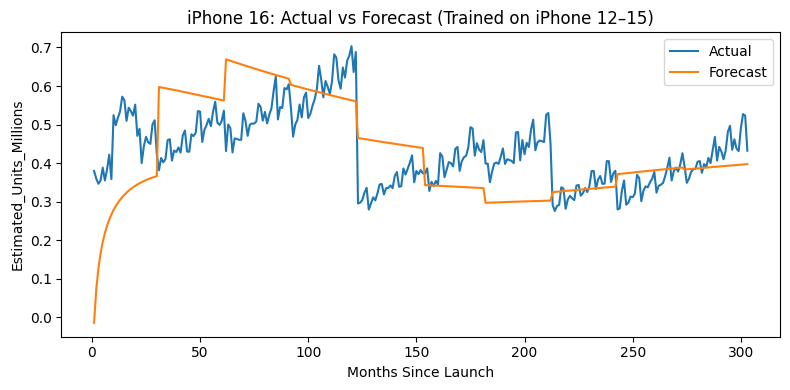

In [35]:

# Plot: iPhone 16 Actual vs Forecast
plt.figure(figsize=(8,4))
sns.lineplot(
    x=test16["months_since_launch"],
    y=test16["Estimated_Units_Millions"],
    label="Actual"
)
sns.lineplot(
    x=test16["months_since_launch"],
    y=y16_pred,
    label="Forecast"
)

plt.xlabel("Months Since Launch")
plt.ylabel(sales_col)
plt.title("iPhone 16: Actual vs Forecast (Trained on iPhone 12–15)")
plt.legend()
plt.tight_layout()
plt.show()


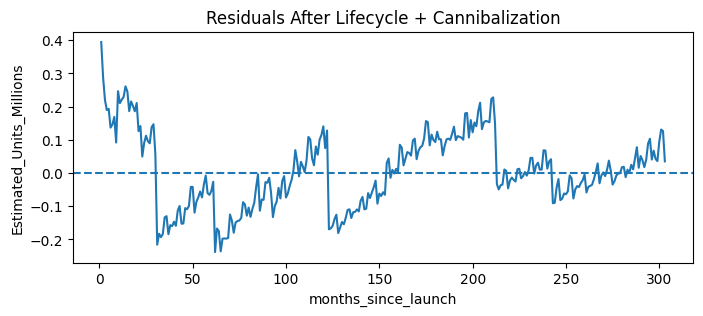

In [36]:
residuals = test16[sales_col] - y16_pred


plt.figure(figsize=(8,3))
sns.lineplot(x=test16["months_since_launch"], y=residuals)
plt.axhline(0, linestyle="--")
plt.title("Residuals After Lifecycle + Cannibalization")
plt.show()


ERROR: 0.0866131110407859


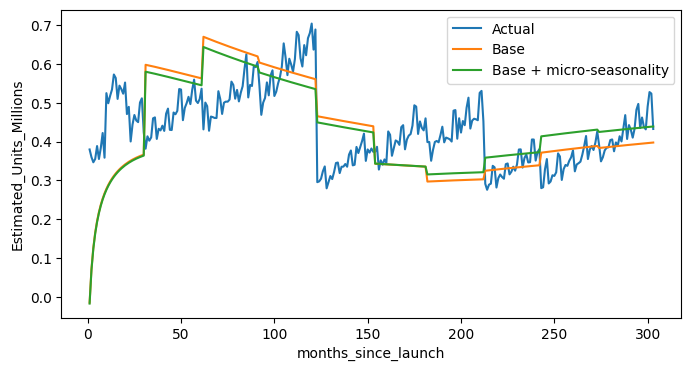

In [37]:


X_res = np.column_stack([
    test16["moy_sin"].values,
    test16["moy_cos"].values
])

ridge_res = Ridge(alpha=50.0)  # strong regularization
ridge_res.fit(X_res, residuals)

residual_pred = ridge_res.predict(X_res)
y_pred_refined = y16_pred + residual_pred
MAE_2_2 = mean_absolute_error(test16[sales_col],y_pred_refined)
print(f"ERROR: {MAE_2_2}")
plt.figure(figsize=(8,4))
sns.lineplot(x=test16["months_since_launch"], y=test16[sales_col], label="Actual")
sns.lineplot(x=test16["months_since_launch"], y=y16_pred, label="Base")
sns.lineplot(x=test16["months_since_launch"], y=y_pred_refined, label="Base + micro-seasonality")
plt.legend()
plt.show()


The current model captures the dominant lifecycle shape and long-run level shifts in iPhone 16 sales while avoiding the overshoot seen in earlier approaches by separating structural effects from seasonality. However, it models each product independently and therefore cannot learn proportional demand transfer when a new iPhone launches and older models decline. Cannibalization is a cross-product effect and requires a multivariate regression framework that incorporates other models’ sales or total market context. Ridge regression is preferred over ordinary linear regression because these predictors are highly correlated, and regularization stabilizes coefficients and improves generalization. While peak normalization helped correct the initial launch spike, it was a one-time adjustment and does not generalize across seasons, motivating a multivariate approach as a more robust solution.

# Predicting iPhone 17


Forecast: iPhone 17 first 4 months (through mid Jan 2026)
          Date  months_since_launch  moy      pred
0   2016-02-15                    1    2  0.216790
1   2016-03-15                    2    3 -0.171603
2   2016-04-15                    3    4 -0.425502
3   2016-05-15                    4    5 -0.526688
4   2016-06-15                    5    6 -0.487986
..         ...                  ...  ...       ...
115 2025-09-15                  116    9  0.351792
116 2025-10-15                  117   10  0.465597
117 2025-11-15                  118   11  0.544797
118 2025-12-15                  119   12  0.543710
119 2026-01-15                  120    1  0.469439

[120 rows x 4 columns]


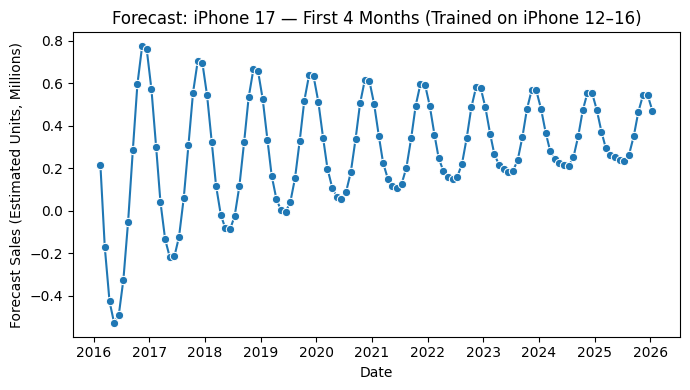

In [38]:


# ========= helpers =========

df_raw = pd.read_csv(CSV_FILE)
df, meta = prep_df(df_raw)

model_col = meta["model_col"]
date_col  = meta["date_col"]
sales_col = meta["sales_col"]

# Train on iPhone 12–16
train = df[df["gen"].between(12, 16)].copy()
if train.empty:
    raise ValueError("No training rows found for iPhone 12–16.")

model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge(alpha=10.0))
])
model.fit(make_X(train), train[sales_col].astype(float).values)



# Forecast iPhone 17 first 4 months through mid Jan 2026
fc17 = forecast_gen(model, meta, target_gen=17, n_months=120, through_date="2026-01-15")

print("\nForecast: iPhone 17 first 4 months (through mid Jan 2026)")
if meta["has_date"]:
    print(fc17[[date_col, "months_since_launch", "moy", "pred"]])
else:
    print(fc17[["_time_sort", "months_since_launch", "moy", "pred"]])
plt.figure(figsize=(7,4))

x_col = meta["date_col"] if meta["has_date"] else "_time_sort"

sns.lineplot(
    data=fc17,
    x=x_col,
    y="pred",
    marker="o"
)

plt.title("Forecast: iPhone 17 — First 4 Months (Trained on iPhone 12–16)")
plt.xlabel("Date")
plt.ylabel("Forecast Sales (Estimated Units, Millions)")
plt.tight_layout()
plt.show()

The oscillatory pattern in the forecast is not an emergent property of the data but a direct consequence of the model design. Seasonality was explicitly encoded using sine and cosine terms to represent a repeating annual cycle, which forces predictions to follow a smooth periodic pattern that persists into the forecast horizon. Because these harmonic features do not decay over time, the sinusoidal behavior continues even beyond the observed data, with its amplitude modulated only by the underlying trend and lifecycle components.


# Share Model- Accounts for Cannibalization

Here instead of modeling the actual number of products sold, we prodict what percentage of annual sales might be sold. This way we dont have to introsuce model complexity but instead account for information and the results are a lot closer. If we have projected total sales of next year we can compute the actual projected unit sales.

What is happening here? 
Here, we predict what portion of the total sales will occur in each day. This was modeled bu creatin individual models for iPhones 12-15 and then each model contributes to the final iPhone 16 prediction, this is by far the best model yet.



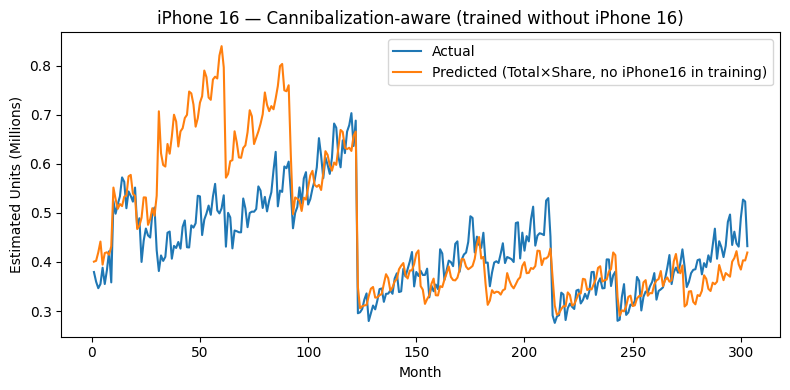

In [39]:
SALES_COL = "Estimated_Units_Millions"
TARGET_MODEL = "iPhone 16"

# --- helpers ---
def fit_share_model(d, degree=3, alpha=1.0):
    d = d[(d["months_since_launch"] >= 1) & (d["total_sales"] > 0)].copy()
    X = np.log1p(d[["months_since_launch"]].values)
    y = d["share"].values
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("ridge", Ridge(alpha=alpha))
    ])
    model.fit(X, y)
    return model



# Ensure Month is datetime (month-start recommended)
df = pd.read_csv(CSV_FILE)


# Build all_months if not already
all_months = sorted(df["Month"].unique())

# ============================================================
# 0) Build a panel that EXCLUDES iPhone 16 (for training totals & shares)
# ============================================================
df_train = df[df["Model"] != TARGET_MODEL].copy()
train_models = sorted(df_train["Model"].unique())

panel_train = (
    df_train.set_index(["Month", "Model"])[SALES_COL]
      .reindex(pd.MultiIndex.from_product([all_months, train_models], names=["Month", "Model"]))
      .fillna(0.0)
      .reset_index()
      .rename(columns={SALES_COL: "sales"})
)

panel_train["total_sales"] = panel_train.groupby("Month")["sales"].transform("sum")
panel_train["share"] = np.where(panel_train["total_sales"] > 0,
                                panel_train["sales"] / panel_train["total_sales"],
                                0.0)

# Launch month computed from ORIGINAL df_train (not panel zeros)
launch_month_train = (
    df_train[df_train[SALES_COL] > 0]
    .groupby("Model")["Month"]
    .min()
    .rename("launch_month")
    .reset_index()
)

panel_train = panel_train.merge(launch_month_train, on="Model", how="left")
panel_train = panel_train.dropna(subset=["launch_month"]).copy()

panel_train["months_since_launch"] = panel_train["Month"] - panel_train["launch_month"] + 1

share_models = {
    m: fit_share_model(panel_train[panel_train["Model"] == m], degree=3, alpha=1.0)
    for m in train_models
}


d16_actual = (
    df[df["Model"] == TARGET_MODEL][["Month", "Model", SALES_COL]]
      .rename(columns={SALES_COL: "sales"})
      .copy()
)

d16_actual = (
    d16_actual.set_index(["Month", "Model"])["sales"]
      .reindex(pd.MultiIndex.from_product([all_months, [TARGET_MODEL]], names=["Month", "Model"]))
      .fillna(0.0)
      .reset_index()
)

launch_16 = d16_actual.loc[d16_actual["sales"] > 0, "Month"].min()
if pd.isna(launch_16):
    raise ValueError("No positive sales found for iPhone 16 to determine launch month.")


# print(d16_actual.columns)

mask16 = d16_actual["Month"] >= 1
X16 = np.log1p(d16_actual.loc[mask16, ["Month"]].values)

share_preds = np.vstack([share_models[m].predict(X16) for m in train_models])
d16_actual["share_pred_raw"] = 0.0
d16_actual.loc[mask16, "share_pred_raw"] = np.mean(share_preds, axis=0)
d16_actual["share_pred_raw"] = d16_actual["share_pred_raw"].clip(lower=0)


total_train = panel_train.groupby("Month")["total_sales"].first().reset_index()
d16_actual = d16_actual.merge(total_train, on="Month", how="left")

d16_actual["sales_pred"] = d16_actual["share_pred_raw"] * d16_actual["total_sales"]

plt.figure(figsize=(8,4))
plot_d16 = d16_actual[d16_actual["sales"] > 0].copy()
sns.lineplot(data=plot_d16, x="Month", y="sales", label="Actual")
sns.lineplot(data=plot_d16, x="Month", y="sales_pred", label="Predicted (Total×Share, no iPhone16 in training)")
plt.title("iPhone 16 — Cannibalization-aware (trained without iPhone 16)")
plt.ylabel("Estimated Units (Millions)")
plt.tight_layout()
plt.show()


In [40]:
MAE_3 = mean_absolute_error(plot_d16['sales_pred'],plot_d16['sales'])
print(f"ERROR : {MAE_3}")

ERROR : 0.0726147986798679


Ablation MAE (normalized sales):
  Lifecycle only  : 0.0944
  Seasonality only: 0.1027
  Full (both)     : 0.0935


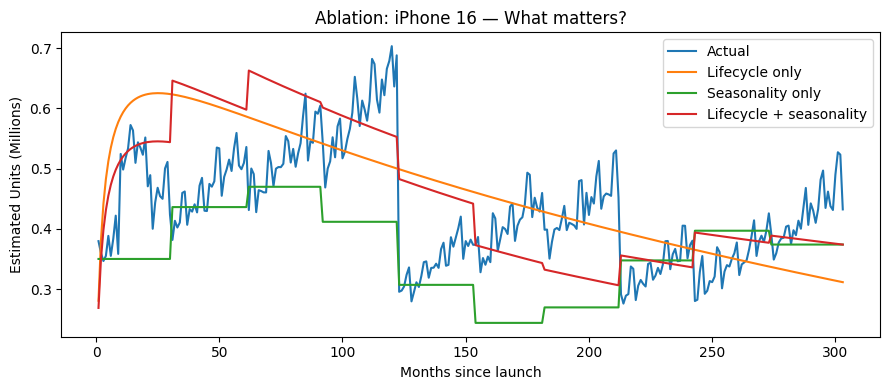

In [41]:

# -------------------------
# 0) Robust config defaults
# -------------------------
# If your notebook already defines these, they will be used.
MODEL_COL = globals().get("MODEL_COL", "Model")
DATE_COL  = globals().get("DATE_COL",  "Month")   # many datasets use "Month"
SALES_COL = globals().get("SALES_COL", "Estimated_Units_Millions")

# Fallback train/test model selection
# If your notebook defines TRAIN_MODELS / TARGET_MODEL, we'll use them.
if "TRAIN_MODELS" in globals():
    TRAIN_MODELS = globals()["TRAIN_MODELS"]
else:
    # take all models except the latest (by sort order) as training
    TRAIN_MODELS = sorted(df[MODEL_COL].unique())[:-1]

TARGET_MODEL = globals().get("TARGET_MODEL", sorted(df[MODEL_COL].unique())[-1])

# -------------------------
# 1) Ensure required columns
# -------------------------
required = [MODEL_COL, DATE_COL, SALES_COL]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in df: {missing}. "
                     f"Available columns: {list(df.columns)}")

work = df.copy()

# Parse date column if possible
if not np.issubdtype(work[DATE_COL].dtype, np.datetime64):
    try:
        work[DATE_COL] = pd.to_datetime(work[DATE_COL])
    except Exception:
        # If it truly isn't a date (e.g., already month index), that's okay for now.
        pass

# months_since_launch: compute within each model
if "months_since_launch" not in work.columns:
    # Sort by date if datetime-like, otherwise by the raw value
    work = work.sort_values([MODEL_COL, DATE_COL]).copy()
    work["months_since_launch"] = work.groupby(MODEL_COL).cumcount() + 1

# Seasonality columns: support both month_sin/cos and moy_sin/cos
if "month_sin" not in work.columns or "month_cos" not in work.columns:
    if "moy_sin" in work.columns and "moy_cos" in work.columns:
        work["month_sin"] = work["moy_sin"]
        work["month_cos"] = work["moy_cos"]
    else:
        if np.issubdtype(work[DATE_COL].dtype, np.datetime64):
            m = work[DATE_COL].dt.month
            work["month_sin"] = np.sin(2*np.pi*m/12)
            work["month_cos"] = np.cos(2*np.pi*m/12)
        else:
            # If we can't infer a calendar month, use a harmless constant seasonality
            work["month_sin"] = 0.0
            work["month_cos"] = 1.0



train_df = work[work[MODEL_COL].isin(TRAIN_MODELS)].copy()
test_df  = work[work[MODEL_COL] == TARGET_MODEL].copy()

if train_df.empty or test_df.empty:
    raise ValueError(
        f"Empty train/test after split. "
        f"TRAIN_MODELS={TRAIN_MODELS}, TARGET_MODEL={TARGET_MODEL}"
    )

# -------------------------
# 3) Normalize sales by per-model peak (training only)
# -------------------------
peak = train_df.groupby(MODEL_COL)[SALES_COL].max().rename("peak_sales")
train_df = train_df.merge(peak, on=MODEL_COL, how="left")
train_df["sales_norm"] = train_df[SALES_COL] / train_df["peak_sales"]

avg_peak = float(peak.mean())
test_df["sales_norm"] = test_df[SALES_COL] / avg_peak


def fit_predict(Xtr, ytr, Xte, degree=2, alpha=10.0):
    m = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("ridge", Ridge(alpha=alpha))
    ])
    m.fit(Xtr, ytr)
    return m.predict(Xte)

# Feature matrices
X_life_tr = np.column_stack([np.log1p(train_df["months_since_launch"].values)])
X_life_te = np.column_stack([np.log1p(test_df["months_since_launch"].values)])

X_seas_tr = np.column_stack([train_df["month_sin"].values, train_df["month_cos"].values])
X_seas_te = np.column_stack([test_df["month_sin"].values, test_df["month_cos"].values])

X_full_tr = np.column_stack([
    np.log1p(train_df["months_since_launch"].values),
    train_df["month_sin"].values,
    train_df["month_cos"].values
])
X_full_te = np.column_stack([
    np.log1p(test_df["months_since_launch"].values),
    test_df["month_sin"].values,
    test_df["month_cos"].values
])

y_tr = train_df["sales_norm"].values
y_te = test_df["sales_norm"].values

pred_life = fit_predict(X_life_tr, y_tr, X_life_te, degree=2, alpha=10.0)
pred_seas = fit_predict(X_seas_tr, y_tr, X_seas_te, degree=2, alpha=10.0)
pred_full = fit_predict(X_full_tr, y_tr, X_full_te, degree=2, alpha=10.0)

# Metrics (normalized)
mae_life = mean_absolute_error(y_te, pred_life)
mae_seas = mean_absolute_error(y_te, pred_seas)
mae_full = mean_absolute_error(y_te, pred_full)

print("Ablation MAE (normalized sales):")
print(f"  Lifecycle only  : {mae_life:.4f}")
print(f"  Seasonality only: {mae_seas:.4f}")
print(f"  Full (both)     : {mae_full:.4f}")


x = test_df["months_since_launch"].values
actual_units = test_df[SALES_COL].values
plt.figure(figsize=(9,4))
plt.plot(x, actual_units, label="Actual")
plt.plot(x, pred_life * avg_peak, label="Lifecycle only")
plt.plot(x, pred_seas * avg_peak, label="Seasonality only")
plt.plot(x, pred_full * avg_peak, label="Lifecycle + seasonality")
plt.title(f"Ablation: {TARGET_MODEL} — What matters?")
plt.xlabel("Months since launch")
plt.ylabel("Estimated Units (Millions)")
plt.legend()
plt.tight_layout()
plt.show()
